# Данный проект решен мною на kaggle.com

https://www.kaggle.com/c/advanced-dls-spring-2021/leaderboard

Достижение - 65 место в leaderboard из более 5000 участников


# Проект -  Предсказание оттока пользователей

# Цель проекта 
- Построить и выбрать лучщую ML-модель классификации

# Описание проекта

Это соревнование является домашним заданием к 3 модулю продвинутого потока DLS. Вам предстоит научитсья моделировать отток клиентов телеком компании. Эта задача очень важна на практике и алгоритмы для ее решения используются в реальных телеком компаниях, ведь если мы знаем, что клиент собирается уйти от нас, то мы попытаться удержать его, предложив какие-то бонусы


# Задачи проекта
- изучить данные, провести предобработку данных
- сформировать и отобрать признаки
- провести обучение на нескольких моделях(ML) с подбором гипперпараметров на кроссвалидации
- выбрать лучшую модель ML и проверить на тестовой выборке, проверить константную модель
- выделить наиболее важные признаки, составить отчет для Заказчика

# Описание данных
- ClientPeriod                
- MonthlySpending             
- TotalSpent                  
- Sex                         
- IsSeniorCitizen             
- HasPartner                  
- HasChild                    
- HasPhoneService             
- HasMultiplePhoneNumbers     
- HasInternetService          
- HasOnlineSecurityService    
- HasOnlineBackup             
- HasDeviceProtection         
- HasTechSupportAccess        
- HasOnlineTV                 
- HasMovieSubscription        
- HasContractPhone            
- IsBillingPaperless          
- PaymentMethod               
- Churn 

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить, используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [2]:
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, f1_score

## Загрузка данных 

1) Посмотрите на случайные строчки.

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [3]:
!gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
!gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv
!gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y  # submission.csv

Downloading...
From: https://drive.google.com/uc?id=1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K
To: /content/train.csv
100% 664k/664k [00:00<00:00, 72.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r
To: /content/test.csv
100% 218k/218k [00:00<00:00, 103MB/s]
Downloading...
From: https://drive.google.com/uc?id=199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y
To: /content/submission.csv
100% 14.7k/14.7k [00:00<00:00, 29.7MB/s]


In [4]:
data = pd.read_csv('./train.csv')

In [5]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [6]:
# вывод первых пяти строк df
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [7]:
# вывод общей информации по df
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [8]:
# вывод информации о пропущенных значениях по признакам в %
data.isna().mean()

ClientPeriod                0.0
MonthlySpending             0.0
TotalSpent                  0.0
Sex                         0.0
IsSeniorCitizen             0.0
HasPartner                  0.0
HasChild                    0.0
HasPhoneService             0.0
HasMultiplePhoneNumbers     0.0
HasInternetService          0.0
HasOnlineSecurityService    0.0
HasOnlineBackup             0.0
HasDeviceProtection         0.0
HasTechSupportAccess        0.0
HasOnlineTV                 0.0
HasMovieSubscription        0.0
HasContractPhone            0.0
IsBillingPaperless          0.0
PaymentMethod               0.0
Churn                       0.0
dtype: float64

In [9]:
# вывод информации о дубликатах по строкам
data.duplicated().sum()

14

## Анализ данных 

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*).

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

**Анализ количественных признаков**

In [10]:
# т.к. тип данных 'TotalSpent' object и м.б. ошибки, заполним 'TotalSpent' через выражение
data['TotalSpent'] = data['ClientPeriod'] * data['MonthlySpending']

In [11]:
# проверим наличие ошибок при переводе типа данных
data['TotalSpent'].isna().sum()

0

In [12]:
# сделаем промежуточную проверку типа данных и проусков в 'TotalSpent' и всем df
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [13]:
# выведем описательную стаьтистику по количествнным признакам
data.describe()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
count,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,2288.109192,0.159409,0.262022
std,24.550326,30.176464,2268.195717,0.366092,0.439776
min,0.000000,18.250000,0.000000,0.000000,0.000000
25%,9.000000,35.462500,392.737500,0.000000,0.000000
50%,29.000000,70.400000,1401.600000,0.000000,0.000000
75%,55.000000,90.050000,3791.975000,0.000000,1.000000
max,72.000000,118.750000,8550.000000,1.000000,1.000000


Графики, гистограммы и диаграммы размаха, численных признаков

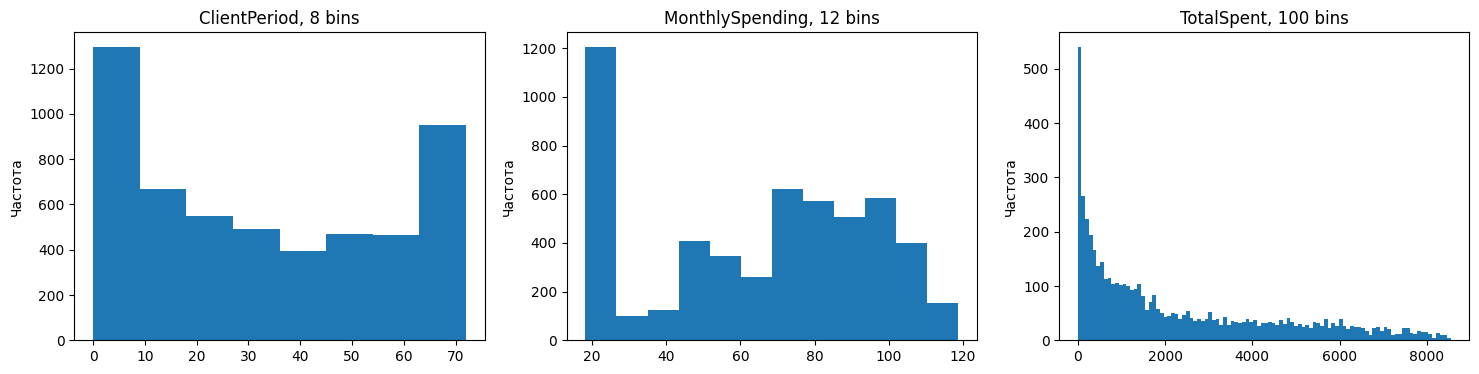

In [14]:
# гистограммы численных признаков - num_cols = ['ClientPeriod', 'MonthlySpending', 'TotalSpent']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
ax[0].hist(data['ClientPeriod'], bins=8)
ax[0].set(title='ClientPeriod'', ''8 bins', ylabel='Частота')
ax[1].hist(data['MonthlySpending'], bins=12)
ax[1].set(title='MonthlySpending'', ''12 bins', ylabel='Частота')
ax[2].hist(data['TotalSpent'], bins=100)
ax[2].set(title='TotalSpent'', ''100 bins', ylabel='Частота')
plt.show()

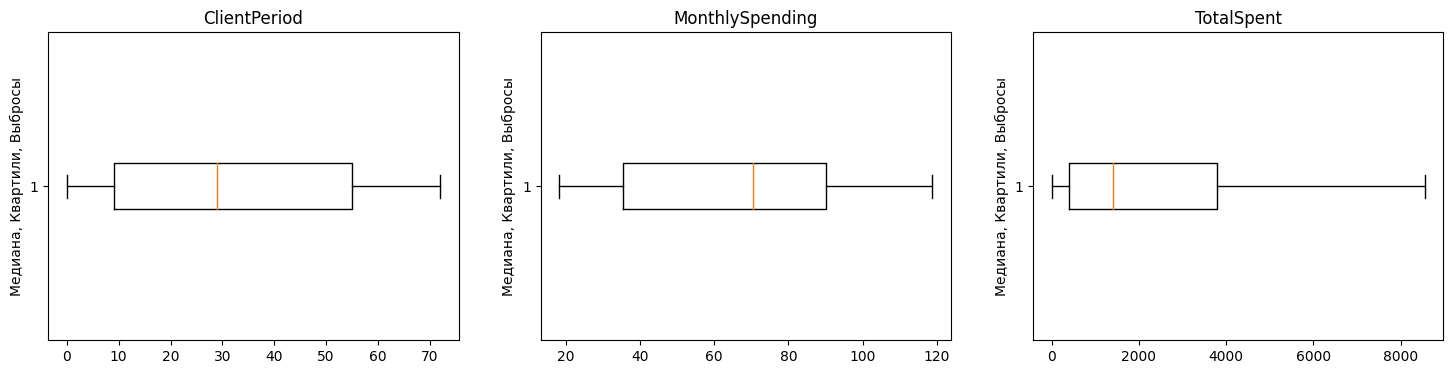

In [15]:
# диаграммы размаха численных признаков - num_cols = ['ClientPeriod', 'MonthlySpending', 'TotalSpent']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
for i, k in enumerate(num_cols):
  ax[i].boxplot(data[k], vert=False)
  ax[i].set(title=k, ylabel='Медиана, Квартили, Выбросы')

**Анализ категориальных признаков**

In [16]:
# вывод данных по категориальным признакам
# Таблица: название признака, количество категорий в признаке, названия категорий, количество значений категорий внтури признака

param_col = ['Признак', 'Категорий в признаке', 'Названия категорий в признаке', 'Количество значений категорий внтури признака', 'Всего объектов']
param_data = []
for i in cat_cols:
  param_data.append([i, len(data[i].value_counts()), data[i].unique(), data[i].value_counts().values, data[i].value_counts().values.sum()])

cat_param = pd.DataFrame(data=param_data, columns=param_col)
cat_param

,Признак,Категорий в признаке,Названия категорий в признаке,Количество значений категорий внтури признака,Всего объектов
0,Sex,2,"[Male, Female]","[2655, 2627]",5282
1,IsSeniorCitizen,2,"[0, 1]","[4440, 842]",5282
2,HasPartner,2,"[Yes, No]","[2705, 2577]",5282
3,HasChild,2,"[Yes, No]","[3676, 1606]",5282
4,HasPhoneService,2,"[Yes, No]","[4761, 521]",5282
5,HasMultiplePhoneNumbers,3,"[No, Yes, No phone service]","[2511, 2250, 521]",5282
6,HasInternetService,3,"[No, Fiber optic, DSL]","[2341, 1800, 1141]",5282
7,HasOnlineSecurityService,3,"[No internet service, No, Yes]","[2612, 1529, 1141]",5282
8,HasOnlineBackup,3,"[No internet service, No, Yes]","[2332, 1809, 1141]",5282
9,HasDeviceProtection,3,"[No internet service, No, Yes]","[2317, 1824, 1141]",5282


In [17]:
# отдельный вывод value_count (количества значений в категории) по категорильным признакам

for i in cat_cols:
  print(i)
  print(data[i].value_counts())
  print()

Sex
Male      2655
Female    2627
Name: Sex, dtype: int64

IsSeniorCitizen
0    4440
1     842
Name: IsSeniorCitizen, dtype: int64

HasPartner
No     2705
Yes    2577
Name: HasPartner, dtype: int64

HasChild
No     3676
Yes    1606
Name: HasChild, dtype: int64

HasPhoneService
Yes    4761
No      521
Name: HasPhoneService, dtype: int64

HasMultiplePhoneNumbers
No                  2511
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64

HasInternetService
Fiber optic    2341
DSL            1800
No             1141
Name: HasInternetService, dtype: int64

HasOnlineSecurityService
No                     2612
Yes                    1529
No internet service    1141
Name: HasOnlineSecurityService, dtype: int64

HasOnlineBackup
No                     2332
Yes                    1809
No internet service    1141
Name: HasOnlineBackup, dtype: int64

HasDeviceProtection
No                     2317
Yes                    1824
No internet service    1141
Na

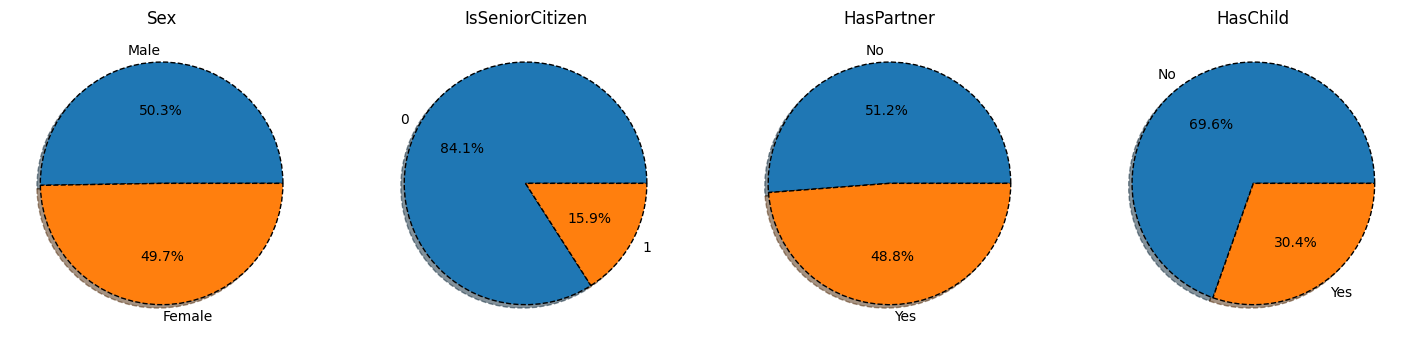

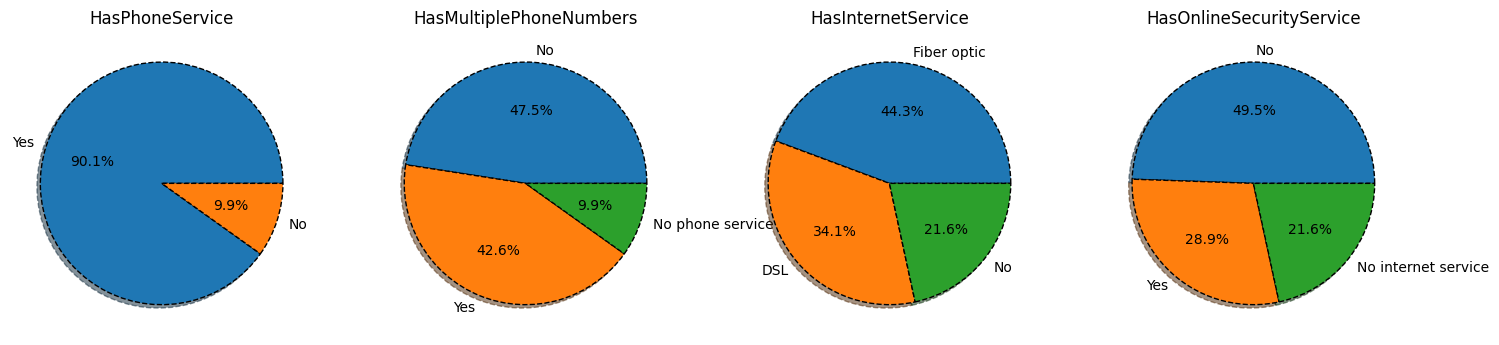

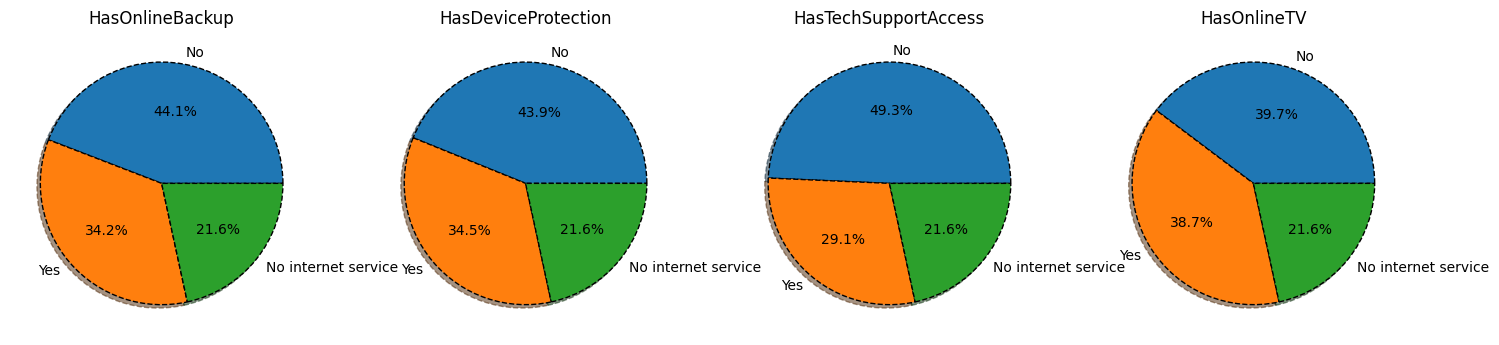

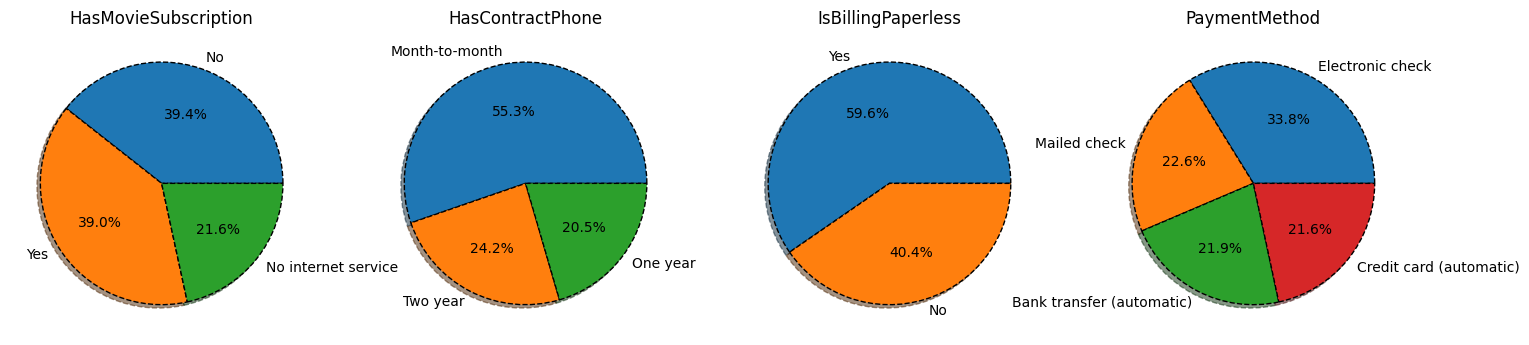

In [18]:
# круговые диаграммы числовых признаков

for j in range(4):
  fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))
  for i, k in enumerate(cat_cols[j*4:((j*4)+4)]):
    ax[i].pie(data[k].value_counts(), labels = data[k].value_counts().index, autopct='%1.1f%%', wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, shadow=True)
    ax[i].set(title=k)

**Вывод соотношение классов целевой переменной data['Churn']**

In [19]:
# вывод соотношение классов целевой переменной data['Churn']
data['Churn'].value_counts()

0    3898
1    1384
Name: Churn, dtype: int64

In [20]:
# соотношение классов целевой переменной data['Churn']
print('Сотношение классов', round(data['Churn'].value_counts()[0]/ data['Churn'].value_counts()[1],1), 'к 1')

Сотношение классов 2.8 к 1


(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

In [21]:
# удалим дубликаты
data = data.drop_duplicates().reset_index(drop=True)

In [22]:
# проверка на дубликаты после удаления
data.duplicated().sum()

0

Выводы, информация по dataframe train:
- 5282 объекта, 19 колонок(признаки)
- пропущеных данных нет
- есть явные дубликаты по строкам (объектам) - 14 шт
- сотношение классов целевой переменной 2.8 к 1

Предобработка данных:
- удалили явные дубликаты по строкам
- изменили тип данных в колонке TotalSpent

После предобработке данных в df:
- 5268 объекта, 19 колонок(признаки)

In [23]:
# итоговый вывод df после предобработки
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5268 non-null   int64  
 1   MonthlySpending           5268 non-null   float64
 2   TotalSpent                5268 non-null   float64
 3   Sex                       5268 non-null   object 
 4   IsSeniorCitizen           5268 non-null   int64  
 5   HasPartner                5268 non-null   object 
 6   HasChild                  5268 non-null   object 
 7   HasPhoneService           5268 non-null   object 
 8   HasMultiplePhoneNumbers   5268 non-null   object 
 9   HasInternetService        5268 non-null   object 
 10  HasOnlineSecurityService  5268 non-null   object 
 11  HasOnlineBackup           5268 non-null   object 
 12  HasDeviceProtection       5268 non-null   object 
 13  HasTechSupportAccess      5268 non-null   object 
 14  HasOnlin

## Применение линейных моделей 

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а.

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC.

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C).


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [24]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

Полготовим данные для обучения на линейной модели:
- переведем категориальные признаки в числовые методом One-hot кодирование
- стандартизируем числовые признаки
- разделим выборку на train и target


Обучение будем делать с использованеим Кросс-валидации методом GridSearchCV


In [25]:
# закодируем категориальные признаки используя функцию pd.get_dummies()
X_train_dummy = pd.get_dummies(data[cat_cols], drop_first=True)

In [26]:
# стандартизируем числовые признаки
scaler = StandardScaler()
data_scalled = data.copy()
data_scalled[num_cols] = scaler.fit_transform(data_scalled[num_cols])

In [27]:
# соединим в новый df числовые и категориальные признаки
X_train_dummy_scaled = pd.concat([X_train_dummy, data_scalled[num_cols]], axis=1)
X_train_dummy_scaled.head(3)

,IsSeniorCitizen,Sex_Male,HasPartner_Yes,HasChild_Yes,HasPhoneService_Yes,HasMultiplePhoneNumbers_No phone service,HasMultiplePhoneNumbers_Yes,HasInternetService_Fiber optic,HasInternetService_No,HasOnlineSecurityService_No internet service,...,HasMovieSubscription_Yes,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,ClientPeriod,MonthlySpending,TotalSpent
0,0,1,1,1,1,0,0,0,1,1,...,0,1,0,0,0,0,1,0.918149,-1.507219,-0.538602
1,0,1,1,0,1,0,1,0,1,1,...,0,0,1,0,1,0,0,1.611260,-1.296767,-0.190857
2,0,1,0,0,1,0,0,1,0,0,...,0,0,0,1,0,1,0,-1.283496,0.361992,-0.978013


In [28]:
y_train = data['Churn']

In [29]:
# выведем размеры выборок
print(X_train_dummy_scaled.shape, y_train.shape)

(5268, 30) (5268,)


Обучение линейной модели с использованеим Кросс-валидации методом GridSearchCV

In [30]:
# обучение LogisticRegression() на кросс-валидации

params = {'solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
          'C': [100, 10, 1, 0.1, 0.01, 0.001],
          'max_iter': [100, 200, 300, 400, 500, 600, 700, 800],
          'class_weight': ['balanced']
         }

grid_LR = GridSearchCV(estimator=LogisticRegression(random_state=123),
                            param_grid=params,
                            cv=3,
                            scoring='f1',
                            n_jobs=-1,
                            verbose=False)


In [31]:
%%time
# подбор параметров на fit

LR_model = grid_LR.fit(X_train_dummy_scaled, y_train)

CPU times: user 2.23 s, sys: 295 ms, total: 2.53 s
Wall time: 1min 12s


In [32]:
# вывод лучшей модели
print(LR_model.best_estimator_)

# вывод лучшей оценки
print(LR_model.best_score_)

# вывод параметров лучшей модели
print(LR_model.best_params_)

LogisticRegression(C=0.1, class_weight='balanced', random_state=123)
0.6205369462614776
{'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'solver': 'lbfgs'}


In [33]:
# обучение лучшей модели на всей выборке
LR_model.best_estimator_.fit(X_train_dummy_scaled, y_train)

probabilities_train = LR_model.best_estimator_.predict_proba(X_train_dummy_scaled)
probabilities_one_train = probabilities_train[:, 1]

# расчет auc_roc на train на лучшей модели
train_roc_auc_score = roc_auc_score(y_train, probabilities_one_train)
print('Оценка roc_auc_score равна = ', round(train_roc_auc_score,4))

Оценка roc_auc_score равна =  0.8473


Выпишите, какое лучшее качество и с какими параметрами вам удалось получить

Оценка roc_auc_score на модели Линейной регресии равна =  0.8473

Параметры модели:
 - LogisticRegression()
 - C=0.1
 - class_weight='balanced'
 - max_iter=400

# Проверка модели LogisticRegression на тестовой выборке

In [34]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv', index_col='Id')

In [35]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

In [36]:
# т.к. тип данных 'TotalSpent' object и при м.б. ошибки, заполним 'TotalSpent' через выражение
X_test['TotalSpent'] = X_test['ClientPeriod'] * X_test['MonthlySpending']

In [37]:
# переведем категориальные признаки X_test в числовые, используем функцию pd.get_dummies()
X_test_dummy = pd.get_dummies(X_test[cat_cols], drop_first=True)

# стандартизируем числовые признаки
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [38]:
# соединим в новый df числовые и категориальные признаки
X_test_dummy_scaled = pd.concat([X_test_dummy, X_test[num_cols]], axis=1)
X_test_dummy_scaled.shape

(1761, 30)

In [39]:
#submission['Churn'] =  best_model.predict_proba(X_test_dummy_scaled)[:, 1]  #  best_model.predict(X_test)  #
submission.to_csv('./my_submission_LR.csv')

## Применение градиентного бустинга 

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с параметрами по умолчанию даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. Catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию.

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [40]:
!pip install catboost

In [41]:
import catboost

In [42]:
X = data.drop(['Churn'], axis=1)
y = data['Churn']

In [43]:
print(X.shape, y.shape)

(5268, 19) (5268,)


In [44]:
boosting_model = catboost.CatBoostClassifier(random_state=123, cat_features=cat_cols, eval_metric='AUC', verbose=False)

params_CBC = {'depth': [2,3,4,5,6],
              'iterations': [200,300,400,500,600],
              'learning_rate' : [0.1, 0.3],
              'auto_class_weights': ['Balanced']
             }

CBC_grid = GridSearchCV(estimator = boosting_model,
                         param_grid=params_CBC,
                         cv=3,
                         scoring='f1',
                         n_jobs=-1
                        )

In [45]:
%%time
# подбор параметров на fit

CBC_model = CBC_grid.fit(X, y)

CPU times: user 10.6 s, sys: 1.41 s, total: 12 s
Wall time: 11min 18s


In [46]:
# вывод лучшей модели
print(CBC_model.best_estimator_)

# вывод лучшей оценки
print(CBC_model.best_score_)

# вывод параметров лучшей модели
print(CBC_model.best_params_)

0.6212820802043616
{'auto_class_weights': 'Balanced', 'depth': 2, 'iterations': 200, 'learning_rate': 0.1}


In [53]:
# обучение лучшей модели на всей выборке
CBC_model.best_estimator_.fit(X, y)

# расчет auc_roc на train на лучшей модели
probabilities_X = CBC_model.best_estimator_.predict_proba(X)
CBC_roc_auc_score = roc_auc_score(y_train, probabilities_X[:, 1])
print('Оценка roc_auc_score равна = ', round(CBC_roc_auc_score,4))

Оценка roc_auc_score равна =  0.858


Вывод feature_importances лучшей модели

In [48]:
# вывод feature_importances лучшей модели

importances = CBC_model.best_estimator_.feature_importances_
feature_list = list(X.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

# 10 самых значимых признаков
feature_results.head(10)

,feature,importance
0,HasContractPhone,43.168086
1,ClientPeriod,12.689642
2,HasOnlineSecurityService,9.784823
3,HasInternetService,9.220770
4,TotalSpent,5.473509
5,MonthlySpending,5.432108
6,HasTechSupportAccess,3.983532
7,PaymentMethod,2.389689
8,IsBillingPaperless,1.765842
9,HasOnlineTV,1.257395


In [49]:
# доля 10 значимых признаков
print('Доля 10-ти значимых признаков = ', round(feature_results.importance.head(10).sum(),2) ,'%', sep='')

Доля 10-ти значимых признаков = 95.17%


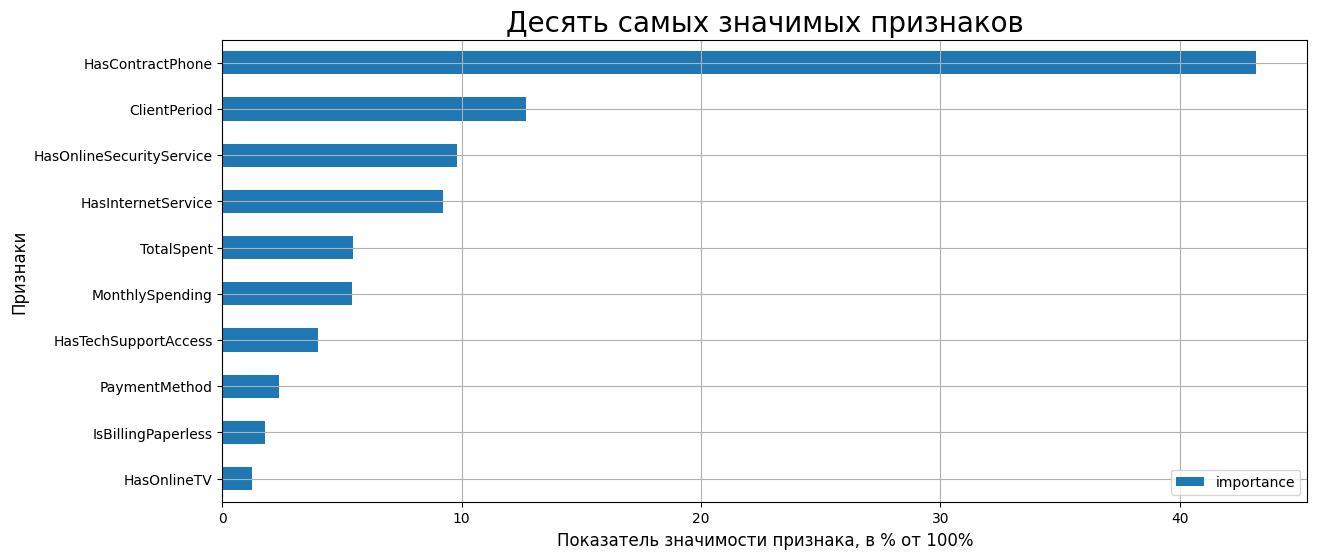

In [50]:
feature_results.head(10).sort_values(by='importance').plot(kind='barh', x='feature', y='importance', grid=True, figsize=(14,6))
plt.xlabel('Показатель значимости признака, в % от 100%', fontsize=12)
plt.ylabel('Признаки', fontsize=12)
plt.title('Десять самых значимых признаков', fontsize=20);

Проверка модели CatBoostClassifier на тестовой выборке

In [51]:
submission['Churn'] = CBC_model.best_estimator_.predict_proba(X_test)[:, 1]
submission.to_csv('./my_submission_CBC.csv')

# Выводы, информация:

- лучшая оценка auc_roc на обучающей выборке у модели CatBoostClassifier:

    - оценка roc_auc_score равна =  0.858


- параметры модели:

    - catboost.core.CatBoostClassifier
    - {'auto_class_weights': 'Balanced', 'depth': 2, 'iterations': 200, 'learning_rate': 0.1}


- десять наиболее значимых признаков в данных для рещшения задачи:
    - 'HasContractPhone'
    - 'ClientPeriod'
    - 'HasOnlineSecurityService'
    - 'HasInternetService'
    - 'TotalSpent'
    - 'MonthlySpending'
    - 'HasTechSupportAccess'
    - 'PaymentMethod'
    - 'IsBillingPaperless'
    - 'HasOnlineTV'


